In [121]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import sklearn as sk
from sklearn.model_selection import train_test_split

In [58]:
## Read Data 
data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv')

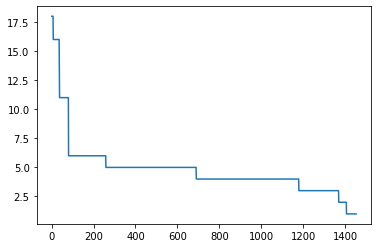

In [59]:
## Cleaning missing values and determining which columns to drop
sum_na = data.isna().sum()
bad_cols = [len(np.where(sum_na > i)[0]) for i in range(1, max(sum_na))]
fig, axis = plt.subplots() 
axis.plot(range(1, max(sum_na)), bad_cols) 
# 100 NAs seem to be a good cutoff 
data = data.drop(columns = data.columns[np.where(sum_na > 1)[0]]) 
data = data.drop(columns = 'Id')

In [62]:
## Create categorical/binary features 
categorical_cols = data.iloc[:, np.where(data.dtypes == 'object')[0]].columns
uniques_type = [len(pd.unique(data[i])) for i in categorical_cols] 
new_dummies = []
for count,length in enumerate(uniques_type):
    if length  == 2: 
        data[categorical_cols[count]] = [1 if j == pd.unique(j)[0] else 0 for j in data[categorical_cols[count]]]  
    else:  
         new_dummies.append(pd.get_dummies(data[categorical_cols[count]]))
## Create a new dataframe of all the categorical variables 
d = {k:v for k,v in enumerate(new_dummies)}
# Store column names
col = []
for key, item in d.items():
    col.append(item.columns)
col_names = [item for sublist in col for item in sublist]
categorical = pd.concat(d, axis = 1, ignore_index = True)

In [63]:
## Append categorical variables to working dataset
categorical.columns = col_names
full_data = pd.concat([data, categorical], axis =1)
## Drop original categorical columns 
full_data = full_data.drop(columns = categorical_cols)

In [64]:
y = full_data['SalePrice']
x = full_data.drop(columns = 'SalePrice')
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .2)

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression

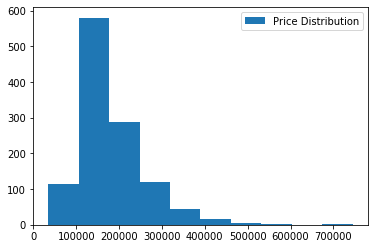

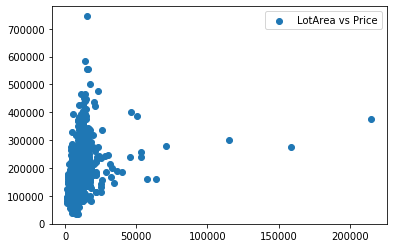

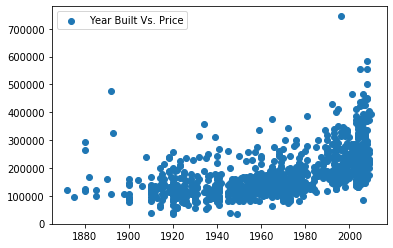

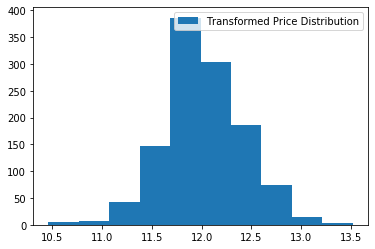

In [123]:
## Look at different relationships
plt.hist(y_train, label = 'Price Distribution')
plt.legend()
plt.figure(2)
plt.scatter(x_train['LotArea'], y_train, label = 'LotArea vs Price')
plt.legend()
plt.figure(3)
plt.scatter(x_train['YearBuilt'], y_train, label = 'Year Built Vs. Price')
plt.legend() 

## Price seems to be right skewed so we take the Log() to transform it to be normally distributed  
plt.figure(4)
plt.hist(np.log(y_train), label = 'Transformed Price Distribution')
plt.legend()

In [124]:
## Transform predictor variable
y_train = np.log(y_train)
y_test = np.log(y_test)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

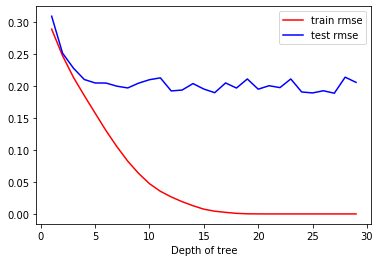

In [125]:
## Decision Tree Regressor  
train_d_scores = []
test_d_scores = []
for i in range(1, 30):
    d = DecisionTreeRegressor(max_depth = i)
    d.fit(x_train, y_train)
    train_d_scores.append((mean_squared_error(y_train, d.predict(x_train)))**.5)
    test_d_scores.append((mean_squared_error(y_test, d.predict(x_test)))**.5)
figure, axis = plt.subplots() 
axis.plot(range(1,30), train_d_scores, color = 'red', label = 'train rmse')
axis.plot(range(1,30), test_d_scores, color = 'blue', label = 'test rmse')
axis.set_xlabel('Depth of tree')
axis.legend() 

## Based on plot below, depth of 5 is a reasonable depth for the model  
d_model = DecisionTreeRegressor(max_depth = 4)
d_model.fit(x_train, y_train)

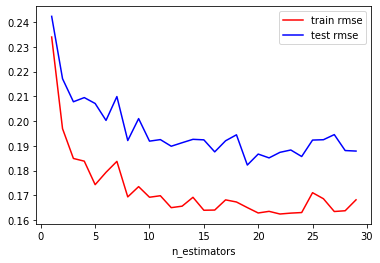

In [126]:
## Random Forest Regressor  
train_rf_mse = []
test_rf_mse = []
for i in range(1, 30):
    rf = RandomForestRegressor(max_depth = 5, n_estimators = i, max_features = int(len(x_train.columns)**.5))
    rf.fit(x_train, y_train)
    train_rf_mse.append((mean_squared_error(y_train, rf.predict(x_train)))**.5)
    test_rf_mse.append((mean_squared_error(y_test, rf.predict(x_test)))**.5)
figure, axis = plt.subplots() 
axis.plot(range(1,30), train_rf_mse, color = 'red', label = 'train rmse')
axis.plot(range(1,30), test_rf_mse, color = 'blue', label = 'test rmse')
axis.set_xlabel('n_estimators')
axis.legend()  

## The number of estimators does not seem to significantly effect after 5 

In [134]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [135]:
## Standardize data and perform Lasso and Ridge regularization
scaler = StandardScaler()
scaler_fitted = scaler.fit(x_train)
s_x_train = scaler_fitted.transform(x_train)
s_x_test = scaler_fitted.transform(x_test)
ridge = Ridge()
r_model = ridge.fit(s_x_train, y_train) 
rmse_ridge = mean_squared_error(y_test, r_model.predict(s_x_test)) **.5 
lasso = Lasso(max_iter=10000)
l_model = lasso.fit(s_x_train, y_train)  
rmse_lasso = mean_squared_error(y_test, l_model.predict(s_x_test)) ** .5  
print('test rmse for Ridge is ', rmse_ridge)
print('test rmse for Lasso is ', rmse_lasso)

test rmse for Ridge is  0.11888437330066848
test rmse for Lasso is  0.4075497498589725


Predictors taken to zero are   Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'ConLI', 'ConLw', 'New', 'Oth', 'WD', 'Abnorml', 'AdjLand', 'Alloca',
       'Family', 'Normal'],
      dtype='object', length=214)


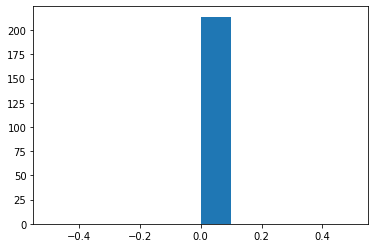

In [136]:
## Look at non-important coef that Lasso took to zero
print('Predictors taken to zero are  ', full_data.columns[np.where(l_model.coef_ == 0)[0]])
plot = plt.hist(l_model.coef_)
## All coef are taken to near zero by Lasso which is interesting

In [138]:
## Greatest coefficients under Ridge Regularization 
print(pd.Series(abs(r_model.coef_)).sort_values(ascending = False)[0:10]) 
top_ten_r = pd.Series(abs(l_model.coef_)).sort_values(ascending = False)[0:10].index

115    0.073404
2      0.069687
13     0.067311
4      0.060776
10     0.047160
3      0.041084
11     0.038824
33     0.035487
92     0.033395
1      0.033337
dtype: float64


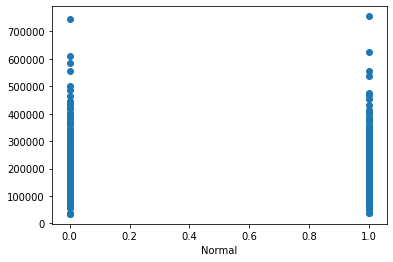

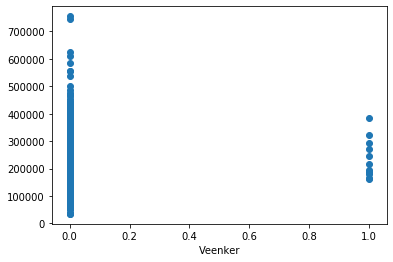

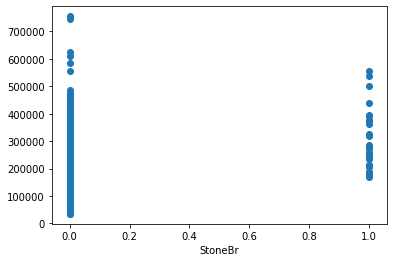

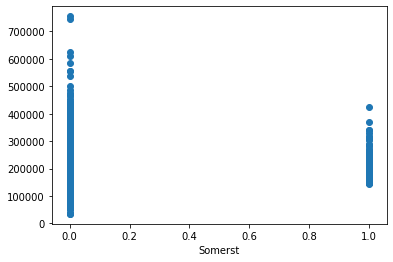

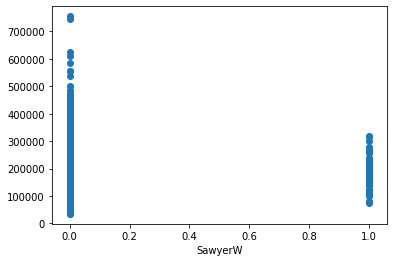

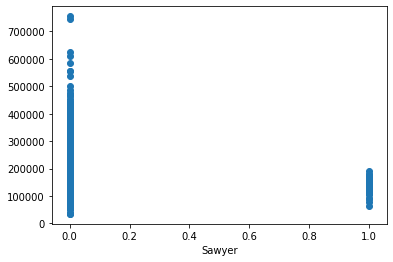

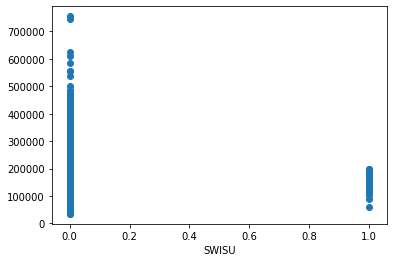

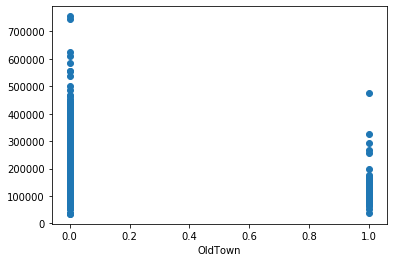

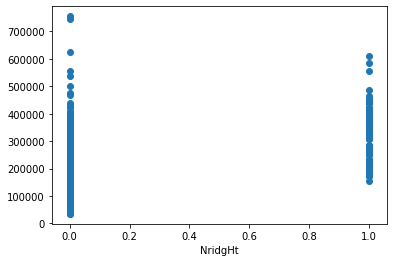

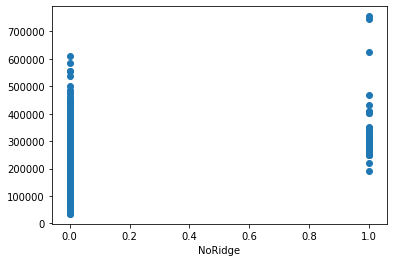

In [140]:
## See some examples of biggest magnitude plotted against the SalePrice
important_factors = full_data.iloc[:, top_ten_r]
for i in range(0, len(important_factors.columns)): 
    col = important_factors[important_factors.columns[i]]
    fig, axis = plt.subplots()
    axis.set_xlabel('%s'%important_factors.columns[i])
    axis.scatter(col, full_data['SalePrice']) 
    
## All binary coefficients